# Chapter 7 - Convolutional Neural Networks

## 7.1. From Fully Connected Layers to Convolutions

### 7.1.1. Invariance

For computer vision,
1. in the earliest layers, our network should respond similarly to the same patch, regardless of where it appears in the image. (*translation invariance*)
2. the earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions. (*locality*) Eventually, these local representations can be aggregated to make predictions at the whole image level.
3. deeper layers should be able to capture longer-range features of the image, in a way similar to higher level vision in nature.

### 7.1.2. Constraining the MLP

Consider an MLP with 2-dimensional images $\mathbf{X}$ as inputs and their immediate hidden representations $\mathbf{H}$ similarly represented as matrices, where both $\mathbf{X}$ and $\mathbf{H}$ have the same shape.

Let $[\mathbf{X}]_{i, j}$ and $[\mathbf{H}]_{i, j}$ denote the pixel at location $(i,j)$ in the input image and hidden representation, respectively.

To have each of the hidden units receive input from each of the input pixels, we need to represent the weights as a **4-dimensional** tensor $\mathsf{W}$, where $[\mathsf{W}]_{i, j, k, l}$ denotes the weight associated with the pixel at location $(k, l)$ in the input image and the hidden unit at location $(i, j)$ in the hidden representation. Suppose that $\mathbf{U}$ contains biases, we could formally express the fully connected layer as
\begin{split}
\begin{aligned}
\left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}
\end{aligned}
\end{split}
The switch from $\mathsf{W}$ to $\mathsf{V}$ is entirely cosmetic for now since there is a one-to-one correspondence between coefficients in both 4-dimensional tensors. We simply re-index the subcscripts $(k, l)$ such that $k=i+a$ and $l=j+b$. In other words, $[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$, where $a$ and $b$ run over both positive and negative offsets, covering the entire image.

For any given location $(i,j)$ in the hidden representation $[\mathbf{H}]_{i, j}$, we compute its value by summing over pixels in $x$ centered around $(i,j)$ and weighted by $[\mathsf{V}]_{i, j, a, b}$.

For a 1-megapixel image ($1000 \times 1000$), we need $1000\times 1000$ hidden representations. This requires $1000\times 1000\times 1000\times 1000 = 10^{12}$ parameters! This is clearly untenable.

#### 7.1.2.1. Translation Invariance

The **translation invaraince** implies that a shift in the input $\mathbf{X}$ should simply lead to a shift in the hidden representation $\mathbf{H}$. This is only possible if $\mathsf{V}$ and $\mathbf{U}$ do not depend on $(i,j)$. In other words, $[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$ and $\mathbf{U} = u$ is a constant. Then, the definition of $\mathbf{H}$ becomes
\begin{split}
[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.
\end{split}
This is a **convolution**. The pixels at $(i+a, j+b)$ are weighted in the vicinity of location $(i,j)$ with coefficients $[\mathbf{V}]_{a, b}$ to obtain the hidden representation $[\mathbf{H}]_{i, j}$.

The number of required parameters reduced from $10^{12}$ to $4\times 10^6$.

#### 7.1.2.2. Locality

Outside some range $|a|> \Delta$ or $|b|> \Delta$, we should set $[\mathbf{V}]_{a, b} = 0$. This is because we do not expect to find any meaningful interactions between pixels that are too far apart. This is the **locality** assumption. This helps to rewrite the definition of $\mathbf{H}$ as
\begin{split}
[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}
\end{split}
This reduces the number of parameters from $4\times 10^6$ to $4\times\Delta^2$, where $\Delta$ is typically smaller than 10. This is what we call a **convolutional layer**.

*Convolutional neural networks* (CNNs) are a special family of neural networks that contain convolutional layers. $\mathbf{V}$ is referred to as a *convolutional kernel*, a *filter*, or the layer's *weights* that are learnable parameters.

The reduction in the number of parameters is paid for the two assumptions that we made: translation invariance and locality. All learning depends on imposing inductive bias. When that bias agrees with reality, we get sample-efficient models that generalize well to unseen data. If those biases do not agree with reality, e.g., if images turned out not to be translation invariant, our models might struggle even to fit the training data.

### 7.1.3. Convolutions

In mathematics, the *convolution* between two functions $f, g: \mathbb{R}^d \to \mathbb{R}$ is defined as
\begin{split}
(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}
\end{split}
We measure the overlap between $f$ and $g$ when one function is "flipped" and shifted by $\mathbf{x}$.

For vectors from the set of square-summable infinite-dimensional vectors with index running over $\mathbb{Z}$, we obtain the following definition:
\begin{split}
(f * g)(i) = \sum_a f(a) g(i-a)
\end{split}

For two-dimensional tensors, we have a corresponding sum with indices $(a,b)$ for $f$ and $(i-a, j-b)$ for $g$, respectively:
\begin{split}
(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b)
\end{split}
Compared to the definition of the convolutional layer, rather than using $(i+a, j+b)$, we use the difference $(i-a, j-b)$. This is a matter of convention. We can always flip the kernel and use $(i+a, j+b)$ instead. The definition of the convolutional layer is more properly called a *cross-correlation*.

### 7.1.4. Channels

Images are represented as 3-dimensional tensors. The first two dimensions correspond to the height and width of the image. The third dimension is called a *channel*. The image $\mathsf{X}$ is indexed as $[\mathsf{X}]_{i, j, k}$, and the convolutional filter has shape $[\mathsf{V}]_{a, b, c}$.

The hidden representations $\mathsf{H}$ are thought as comprising a number of two-dimensional grids stacked on top of each other. As in the inputs, these are sometimes called *channels*. THey are also sometimes called *feature maps*, as each provides a spatialized set of learned features for the subsequent layer.

To support multiple channels in both inputs ($\mathsf{X}$) and hidden representations ($\mathsf{H}$), we add a fourth dimension to the convolutional kernel $\mathsf{V}$: $[\mathsf{V}]_{a, b, c, d}$:
\begin{split}
[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c}
\end{split}
where $d$ indexed the output channels in the hidden representations $\mathsf{H}$.

## 7.2. Convolutions for Images

In [3]:
import torch
import torch.nn as nn

from d2l import torch as d2l

### 7.2.1. The Cross-Correlation Operation

Suppose that the input is two-dimensional data of $3\times 3$ tensor. The convolutional kernel is a $2\times 2$ tensor. The shape of the *kernel window* (or *convolution window*) is given by the shape of the kernel ($2\times 2$):

![](../imgs/ch07/correlation.svg)

In the 2-dimensional cross-correlation operation, we begin with the convolution window positioned at the upper-left corner of the input tensor and slide it across the input tensor, both from left to right and top to bottom. The input subtensor contained in the convolution window and the kernel tensor are multiplied (elementwise) and the resulting tensor is summed up yielding a single scalar value:
\begin{split}
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
\end{split}

Along each axis, the output size is slightly smaller than the input size. For a kernel size greater than 1, the output size is given by the input size $n_h \times n_w$ minus the size of the convolution kernel $k_h \times k_w$ via
\begin{split}
(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1)
\end{split}

In [4]:
def corr2d(X, K):
    '''Compute 2D cross-correlation'''
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, # height
                     X.shape[1] - w + 1 # width
                     ))
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            # Multiply and sum
            Y[i,j] = (X[i:i+h, j:j+w] * K).sum()

    return Y

In [5]:
X = torch.tensor(
    [[0.0, 1.0, 2.0],
     [3.0, 4.0, 5.0],
     [6.0, 7.0, 8.0]]
)

K = torch.tensor(
    [[0.0, 1.0],
     [2.0, 3.0]]
)

corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.2. Convolutional Layers

A convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce an output.

In [6]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        # initialize weight and bias
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

A convolutional layer with an $h\times w$ convolution kernel is an $h\times w$ convolutional layer.

### 7.2.3. Object Edge Detection in Images

Supoose to construct an "image" of $6\times 8$ pixels:

In [7]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

Next, construct a kernel `K` with a height of 1 and a width of 2. This kernel is a special case of a finite difference operator. At location $(i,j)$ it computes $x_{i,j} - x_{(i+1),j}$, the difference between two horizontally adjacent pixels.

In [8]:
K = torch.tensor([[1.0, -1.0]])
K.shape

torch.Size([1, 2])

In [9]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

As we can see, we detect 1 for the edge from white (1) to black (0) and -1 for the edge from black to white.

In [10]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

This proves the kernel `K` only detects vertical edges.

### 7.1.4. Learning a Kernel

We can learn the kernel from the generated `Y` and `X` by convolutional layer. In each training iteration, we use the squared error to compare `Y` with the output of the convolutional layer. Then w calculate the gradient to update the kernel.

In [11]:
# Construct a 2D convolutional layer with 1 output channel and a kernel of shape (1, 2).
# For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(out_channels=1,
                       kernel_size=(1, 2),
                       bias=False)

# The 2D convolutional layer uses 4D input and 
# output in the format (example channel, height, width),
# where the batch size (number of examples in the batch) and
# the number of channels are both equal to 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
# learning rate
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2

    conv2d.zero_grad() # reset gradient
    l.sum().backward() # compute gradient

    # update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad

    if (i+1) % 2 == 0:
        print(f"Epoch {i+1}, Loss {l.sum():.3f}")

Epoch 2, Loss 17.676
Epoch 4, Loss 6.027
Epoch 6, Loss 2.265
Epoch 8, Loss 0.894
Epoch 10, Loss 0.360


c:\Users\User\anaconda3\envs\d2l-env\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
# check the learned kernel
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0500, -0.9267]])

Close to the ideal kernel `K = [[1, -1]]`. 

### 7.2.5. Cross-Correlation and Convolution

Suppose that a convolutional layer performs *cross-correlation* and learns the kernel denoted as the matrix $\mathbf{K}$. Assume that other conditions remain unchanged, when this layer instead performs strict *convolution*, the learned kernel $\mathbf{K}'$ will be the same as $\mathbf{K}$ transposed. This is because the cross-correlation operation flips the kernel matrix left-right and top-bottom before computing the input and kernel tensor element products. Therefore, strict convolution and cross-correlation are equivalent operations but the two are used in different contexts.

### 7.2.6. Feature Map and Receptive Field

The convolutional layer output is also called a *feature map* and regarded as the learned representations (features) in the spatial dimensions (e.g., width and height) to the subsequent layer.

For any element $x$ of some layer in CNNs, its *receptive field* refers to all the elements (from all the previous layers) that may affect the calculation of $x$ during the forward propagation.

![](../imgs/ch07/correlation.svg)

Given the $2\times 2$ convolution kernel, the receptive field of the shaded output element (of value 19) is 4 elements in the shaded portion of the input. Suppose to denote the $2\times 2$ output as $\mathbf{Y}$ and consider a deep CNN with an additional $2\times 2$ convolutional layer that takes $\mathbf{Y}$ as its input, outputting a single element $z$. In this case, the receptive field of $z$ on $\mathbf{Y}$ includes all the 4 elements of $\mathbf{Y}$, while the receptive field on the input includes all the **9** input elements.

Thus, when any element in a feature map needs a larger receptive field to detect input features over a broader area, we can build a deeper network.

## 7.3. Padding and Stride

![](../imgs/ch07/correlation.svg)

The input has both a height and width of 3 and the convolutional kernel has both a height and width of 2, yielding an output representation with dimension $2\times 2$.

Assuming that the input shape is $n_\textrm{h}\times n_\textrm{w}$ and the convolution kernel window shape is $k_\textrm{h}\times k_\textrm{w}$, then the output shape will be $(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1)$.

In [1]:
import torch
from torch import nn

### 7.3.1. Padding

The figure in previous section shows that we tend to lose pixels on the perimeter of the image. 

The figure below depicts the pixel utilization as a function of the convolution kernel size ($1\times 1$, $2\times 2$, and $3\times 3$, respectively) and the position within the image. The pixels in the corners are hardly used at all.

![](../imgs/ch07/conv-reuse.svg)

We may lose a lot of pixels as we apply many successive convolutional layers. One way to address this problem is to add extra pixels around the boundary of the input image, thus increasing the effective size of the image.

![](../imgs/ch07/conv-pad.svg)

This is called *padding*. Here, we pad a $3\times 3$ input, increasing its size to $5\times 5$. The corresponding output then increases to a $4\times 4$ matrix.

In general, if we add a total of $p_\textrm{h}$ rows of padding (roughly half on top and half on bottom) and a total of $p_\textrm{w}$ columns of padding (roughly half on the left and half on the right), the output shape will be
\begin{split}
(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+1)\times(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+1)
\end{split}
which means that the height and width of the output will increase by $p_\textrm{h}$ and $p_\textrm{w}$, respectively.

Typically, we want to set $p_\textrm{h}=k_\textrm{h}-1$ and $p_\textrm{w}=k_\textrm{w}-1$ to give the input and output the same height and width. Assuming that $k_\textrm{h}$ is odd, we will pad $p_\textrm{h}/2$ rows on both sides of the height. If $k_\textrm{h}$ is even, one possibility os to pad $[p_\textrm{h}/2]$ rows on the top of the input and $p_\textrm{h}/2$ rows on the bottom. We will pad both sides of the width in the same way.

CNNs commonly use convolution kernels with odd height and width values, such as 1, 3, 5, or 7. This practice of using odd kernels and padding to precisely preserve dimensionality offers a convenient way to design CNNs with many layers while keeping height and width fixed throughout the network.

Now we can create a 2-dimensional convolutional layer with a height and width of 3 and apply 1 pixel of padding on all sides:

In [2]:
# Define a helper function to calculate convolutions
# It initializes the convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape) # (1, 1, 6, 8) <- tuple concatenation
    Y = conv2d(X)
    # strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

In [11]:
# 1 row and column is padded on either side, so a total of 2 rows or columns
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)

In [12]:
X = torch.rand(size=(8,8))
X.shape

torch.Size([8, 8])

In [13]:
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [14]:
# we use a convolution kernel with height 5 and width 3.
# The padding on either side of the height and width are 2 and 1 respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))

In [15]:
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 7.3.2. Stride

If the convolution kernel is large and captures a large area of the underlying image, we can move our window more than one element at a time, skipping the intermediate locations. We refer to the number of rows and columns traversed per slide as the *stride* of the convolution kernel. By default, the stride is 1 in each dimension. 

![](..imgs/ch07/conv-stride.svg)

The figure above shows a two-dimensional cross-correlation operation with a stride of 3 vertically and 2 horizontally. The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation.

In general, when the stride for the height is $s_\textrm{h}$ and the stride for the width is $s_\textrm{w}$, the output shape is
\begin{split}
\lfloor(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+s_\textrm{h})/s_\textrm{h}\rfloor \times \lfloor(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+s_\textrm{w})/s_\textrm{w}\rfloor
\end{split}
If we set $p_\textrm{h}=k_\textrm{h}-1$ and $p_\textrm{w}=k_\textrm{w}-1$, then the output shape will be simplified to 
\begin{split}
\lfloor(n_\textrm{h}+s_\textrm{h}-1)/s_\textrm{h}\rfloor \times \lfloor(n_\textrm{w}+s_\textrm{w}-1)/s_\textrm{w}\rfloor
\end{split}

Going one step further, if the input height and width are divisible by the strides on the height and width, then the output shape will be
\begin{split}
(n_\textrm{h}/s_\textrm{h}) \times (n_\textrm{w}/s_\textrm{w})
\end{split}

Now we can set a stride of 2 on both the height and width, thus halving the input height and width:

In [17]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
X.shape, comp_conv2d(conv2d, X).shape

(torch.Size([8, 8]), torch.Size([4, 4]))

In [19]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
X.shape, comp_conv2d(conv2d, X).shape

(torch.Size([8, 8]), torch.Size([2, 2]))

## 7.4. Multiple Input and Output Channels

In [20]:
import torch

from d2l import torch as d2l

### 7.4.1. Multiple Input Channels

Assuming that the number of channels for the input data is $c_\textrm{i}$, the number of input channels of the convolution kernel also needs to be $c_\textrm{i}$. If the window size of one convolution kernel is $k_\textrm{h}\times k_\textrm{w}$, then we need to concatenate all $c_\textrm{i}$ tensors together yielding a convolution kernel of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.

Since the input and convolution kernel each have $c_\textrm{i}$ channels, we can perform a cross-correlation operation on the two-dimensional tensor of the input and the two-dimensional tensor of the convolution kernel for each channel, adding the $c_\textrm{i}$ results together (summing over the channels) to yield a two-dimensional tensor. This is the result of a two-dimensional cross-correlation between multi-channel input data and a multi-input-channel convolution kernel.

![](../imgs/ch07/conv-multi-in.svg)

We can implement a cross-correlation operation per channel and then add the results together:

In [21]:
def corr2d_multi_in(X, K):
    # iterate through the 0-th dimension (channel) of K first, and then add them together
    res = sum(d2l.corr2d(x, k) for x,k in zip(X, K))

    return res

In [22]:
X = torch.tensor([
    [[0., 1., 2.],
     [3., 4., 5.],
     [6., 7., 8.]],
    [[1., 2., 3.],
     [4., 5., 6.],
     [7., 8., 9.]],
    ]
)

K = torch.tensor([
    [[0., 1.],
     [2., 3.]],
    [[1., 2.],
     [3., 4.]]
])

X, K

(tensor([[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]],
 
         [[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]),
 tensor([[[0., 1.],
          [2., 3.]],
 
         [[1., 2.],
          [3., 4.]]]))

In [23]:
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2. Multiple Output Channels

In the most popular neural network architectures, we usually increase the channel dimension as we go deeper in the neural network, typically downsampling to trade off spatial resolution for greater *channel depth*.

We can denote the number of input channels and output channels as $c_\textrm{i}$ and $c_\textrm{o}$, respectively, and the height and width of the kernel as $k_\textrm{h}$ and $k_\textrm{w}$, respectively. To get an output with multiple channels, we can create a kernel tensor of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$ for each output channel. We then concatenate them on the output channel dimension, so that the shape of the convolution kernel is $c_\textrm{o}\times c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$. 

We can implement a cross-correlation function to calculate the output of multiple channels:

In [24]:
def corr2d_multi_in_out(X, K):
    # iterate through the 0-th dimension (channel) of K, and
    # each time, perform cross-correlation operations with input X.
    tmp = [corr2d_multi_in(X, k) for k in K]
    
    # All of the results are stacked together
    res = torch.stack(tmp, 0)

    return res

In [25]:
# recall that K has 2 channels, same as the number of channels in X
K.shape

torch.Size([2, 2, 2])

In [26]:
# construct a convolutional layer with 3 output channels
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [28]:
# Perform cross-correlation operations on X with the kernel K with 3 output channels
corr2d_multi_in_out(X, K), corr2d_multi_in_out(X, K).shape

(tensor([[[ 56.,  72.],
          [104., 120.]],
 
         [[ 76., 100.],
          [148., 172.]],
 
         [[ 96., 128.],
          [192., 224.]]]),
 torch.Size([3, 2, 2]))

### 7.4.3. $1\times 1$ Convolutional Layer

The $1\times 1$ convolution loses the ability of larger convolutional layers to recognize patterns consisting of interactions among adjacent elements in the height and width dimensions.

![](../imgs/ch07/conv-1x1.svg)

The figure above shows the cross-correlation computation using $1\times 1$ convolution kernel with 3 input channels and 2 output channels. Note that *the inputs and outputs have the same height and width*. Each element in the output is derived from a linear combination of elements *at the same position* in the input image.

The $1\times 1$ convolutional layer can be thought as a fully-connected layer applied at every single pixel location to transform the $c_\textrm{i}$ corresponding input values into $c_\textrm{o}$ output values. Because this is still a convolutional layer, the weights are tied across pixel location. Thus, the $1\times 1$ convolutional layer requires $c_\textrm{i}\times c_\textrm{o}$ weights (plus the bias). The convolutional layers are typically followed by nonlinearities, which ensures that $1\times 1$ convolutions cannot simply be folded into other convolutions.

We can implement a $1\times 1$ convolutional layer:

In [29]:
def corr2d_multi_in_out_1x1(X, K):
    # X dim
    c_i, h, w = X.shape
    # output dim
    c_o = K.shape[0]

    # reshape input and kernel into 2D tensors
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))

    # Matrix multiplication in the fully-connected layer
    Y = torch.matmul(K, X)
    # reshape back to 3D tensor
    res = Y.reshape((c_o, h, w))

    return res

In [30]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [31]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y1

tensor([[[-0.0741, -0.8394,  0.3837],
         [-1.3727,  1.7865,  0.5925],
         [ 0.5082, -0.6589,  0.2499]],

        [[-2.0459,  2.0197, -1.3441],
         [ 0.3227, -1.4861, -1.6795],
         [-0.3836, -0.6081, -0.8561]]])

In [32]:
Y2 = corr2d_multi_in_out(X, K)
Y2

tensor([[[-0.0741, -0.8394,  0.3837],
         [-1.3727,  1.7865,  0.5925],
         [ 0.5082, -0.6589,  0.2499]],

        [[-2.0459,  2.0197, -1.3441],
         [ 0.3227, -1.4861, -1.6795],
         [-0.3836, -0.6081, -0.8561]]])

When performing $1\times 1$ convolutions, the above function is equivalent to the previously implemented cross-correlation function `corr2d_multi_in_out`.

In [33]:
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

Channels allow us to combine the best of both worlds: MLPs that allow for significant nonlinearities and convolutions that allow for *localized* analysis of features. In particular, channels allow the CNN to reason with multiple features, such as edge and shape detectors at the same time. 

Given an image of size $(h\times w)$, the cost for computing a $k\times k$ convolution is $\mathcal{O}(h \cdot w \cdot k^2)$. For $c_\textrm{i}$ and $c_\textrm{o}$ input and output channels respectively, this increases to $\mathcal{O}(h \cdot w \cdot k^2 \cdot c_\textrm{i} \cdot c_\textrm{o})$.

For example, for a $256\times 256$ pixel image with a $5\times 5$ kernel and 128 input and output channels respectively, this amounts to over 53 billion operations.

## 7.5. Pooling

The deeper we go in the network, the larger the receptive field (relative to the input) to which each hidden node is sensitive. Reducing spatial resolution accelerates this process.

The *pooling layers* serve the dual purposes of mitigating the sensitivity of convolutional layers to location and of spatially downsampling representations.

In [1]:
import torch
from torch import nn

from d2l import torch as d2l

### 7.5.1. Maximum Pooling and Average Pooling

Similar to convolutional layers, the *pooling* operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape window (sometimes known as the *pooling window*).

The pooling layer contains no parameters (there is no *kernel*).

*Average pooling* is akin to downsampling an image and taking the average over adjacent pixels to obtain an image with better signal-to-noise ratio. *Maximum pooling* is preferable to average pooling.

In general, we can define $p\times q$ pooling layer by aggregating over a region of said size. For example, using a $2\times 2$ max-pooling layer, we can detect if the pattern recognized by the convolutional layer moves no more than one element in height or width.

Now we will implement the forward propagation of the pooling layer in the `pool2d` function:

In [2]:
def pool2d(X, pool_size, mode='max'):
    # pooling shape
    p_h, p_w = pool_size

    # output shape
    Y = torch.zeros((X.shape[0] - p_h + 1, # height
                     X.shape[1] - p_w + 1 # width
                     ))
    
    # iterate through the output array
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                # max pooling
                Y[i,j] = X[i : i + p_h, j : j + p_w].max()
            elif mode == 'avg':
                # average pooling
                Y[i,j] = X[i : i + p_h, j : j + p_w].mean()

    return Y

In [4]:
X = torch.tensor(
    [[0.0, 1.0, 2.0],
     [3.0, 4.0, 5.0],
     [6.0, 7.0, 8.0]]
)

pool2d(X, (2, 2), 'max')

tensor([[4., 5.],
        [7., 8.]])

In [5]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2. Padding and Stride

We can adjust the pooling operation to achieve a desired output shape by padding the input and adjusting the stride.

In [6]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Deep learning frameworks default to matching pooling window sizes and stride. For example, if we use a pooling window of shape `(3, 3)`, we will get a stride shape of `(3, 3)` by default:

In [7]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [8]:
# specify a padding and stride mannually
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [9]:
# specify a non-square pooling window and padding
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3. Multiple Channels

When processing multi-channel input data, the pooling layer pools each input channel separately, rather than summing the inputs up over channels as in a convolutional layer.

The number of output channels for the pooling layer is the same as the number of input channels.

In [10]:
X = torch.cat((X, X + 1), 1)
X.shape, X

(torch.Size([1, 2, 4, 4]),
 tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]],
 
          [[ 1.,  2.,  3.,  4.],
           [ 5.,  6.,  7.,  8.],
           [ 9., 10., 11., 12.],
           [13., 14., 15., 16.]]]]))

In [11]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

Pooling is indiffernet to channels, i.e., it leaves the number of channels unchanged and it applies to each channel separately.

Stochastic pooling and fractional max-pooling are two common variations of the max-pooling layer, which can slightly improve the accuracy in some cases.

## 7.6. Convolutional Neural Networks (LeNet)

In [12]:
import torch
from torch import nn

from d2l import torch as d2l

### 7.6.1. LeNet

![](../imgs/ch07/lenet.svg)

LeNet (LeNet-5) consists of two parts:
1. a convolutional encoder consisting of two convolutional layers, and
2. a dense block consisting of three fully-connected layers.

The basic units in each convolutional block are a convolutional layer followed by a *sigmoid* activation function and a *average pooling* layer. Each convolutional layer uses a $5\times 5$ kernel and a sigmoid activation function. The first convolutional layer has 6 output channels, while the second has 16. Each $2\times 2$ pooling operation (stride 2) reduces dimensionality by a factor of 4 via spatial downsampling. The convolutional block emits an output with shape given by `(batch size, channel, height, width)`.

In order to pass output from the convolutional block to the dense block, we must flatten each example in the minibatch. In other words, we take this 4D input and transform it into the 2D input expected by fully-connected layers.

LeNet's dense block has three fully-connected layers, with 120, 84, and 10 outputs, respectively.

We can implement LeNet with a `Sequential` block and Xavier initialization:

In [18]:
def init_cnn(module):
    '''Initialize weights for CNNs'''
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [14]:
class LeNet(d2l.Classifier):
    '''LeNet-5 Model'''
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        
        self.net = nn.Sequential(
            # first convolutional block
            nn.LazyConv2d(6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            # second convolutional block
            nn.LazyConv2d(16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            # fully connected layers to output
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

![](../imgs/ch07/lenet-vert.svg)

By passing a single-channel (black and white) $28\times 28$ image through the network and printing the output shape at each layer, we can inspect the model to ensure that its operations line up with our expectations:

In [15]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    # X_shape: (batch_size, channels, height, width)
    X = torch.randn(*X_shape)

    # print the shape of each layer
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [17]:
model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


The height and width of the representation at each layer throughout the convolutional block is reduced (compared with the previous layer).

As we go up the stack of layers, the number of channels increases layer-over-layer from 1 in the input to 6 after the first convolutional layer and 16 after the second convolutional layer. Each pooling layer halves the height and width.

### 7.6.2. Training

The `d2l.Trainer` class takes care of all details. By default, it initalizes the model parameters on the available devices. Just as with MLPs, our loss function is cross-entropy, and we minimize it via minibatch stochastic gradient descent:

In [20]:
# create a trainer instance
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
# load data
data = d2l.FashionMNIST(batch_size=128)

# create a LeNet model
model = LeNet(lr=0.1)
# initialize weights
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

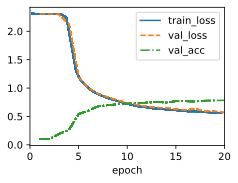

In [21]:
# train the model
trainer.fit(model, data)